In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./compression-data.csv', sep=';')

In [3]:
data = data.sort_values('cells')
#data = data[data['cells'] > 0]
fulldata = data
data

,cells,bytes,build_duration_nanosec,build_duration_total_nanosec,retr_duration_avg_nanosec,algorithm,table
443,1282172,97589344,101511012,8256431289,2744,baseline,main_tokenized
46,2691359,8035064,358139014,10428638346,371,dedup_btree,main_tokenized_embedding
37,2953720,6132768,433504598,12635191276,254,ns,main_tokenized
449,6847260,407756520,423847487,10668472271,362,baseline,main_tokenized
56,7572223,16621648,881091185,14860034516,475,dedup_btree,cocoa_main_tokenized
...,...,...,...,...,...,...,...
222,1586433715,24421548544,207376438643,387208357651,1009,ns,gittables_main_tokenized
167,1586435541,42154694344,155635782300,591700168404,16696,dedup_btree,gittables_main_tokenized
194,1588021298,42180820864,128995117730,431698462755,3241,dedup_btree,gittables_main_tokenized
221,1588021298,39465052304,147221973909,467141792557,814,dedup_hash,gittables_main_tokenized


In [4]:
c = {
    'ns': 'red',
    'baseline': 'blue',
    'dedup_hash': 'orange',
    'dedup_btree': 'violet',
}   


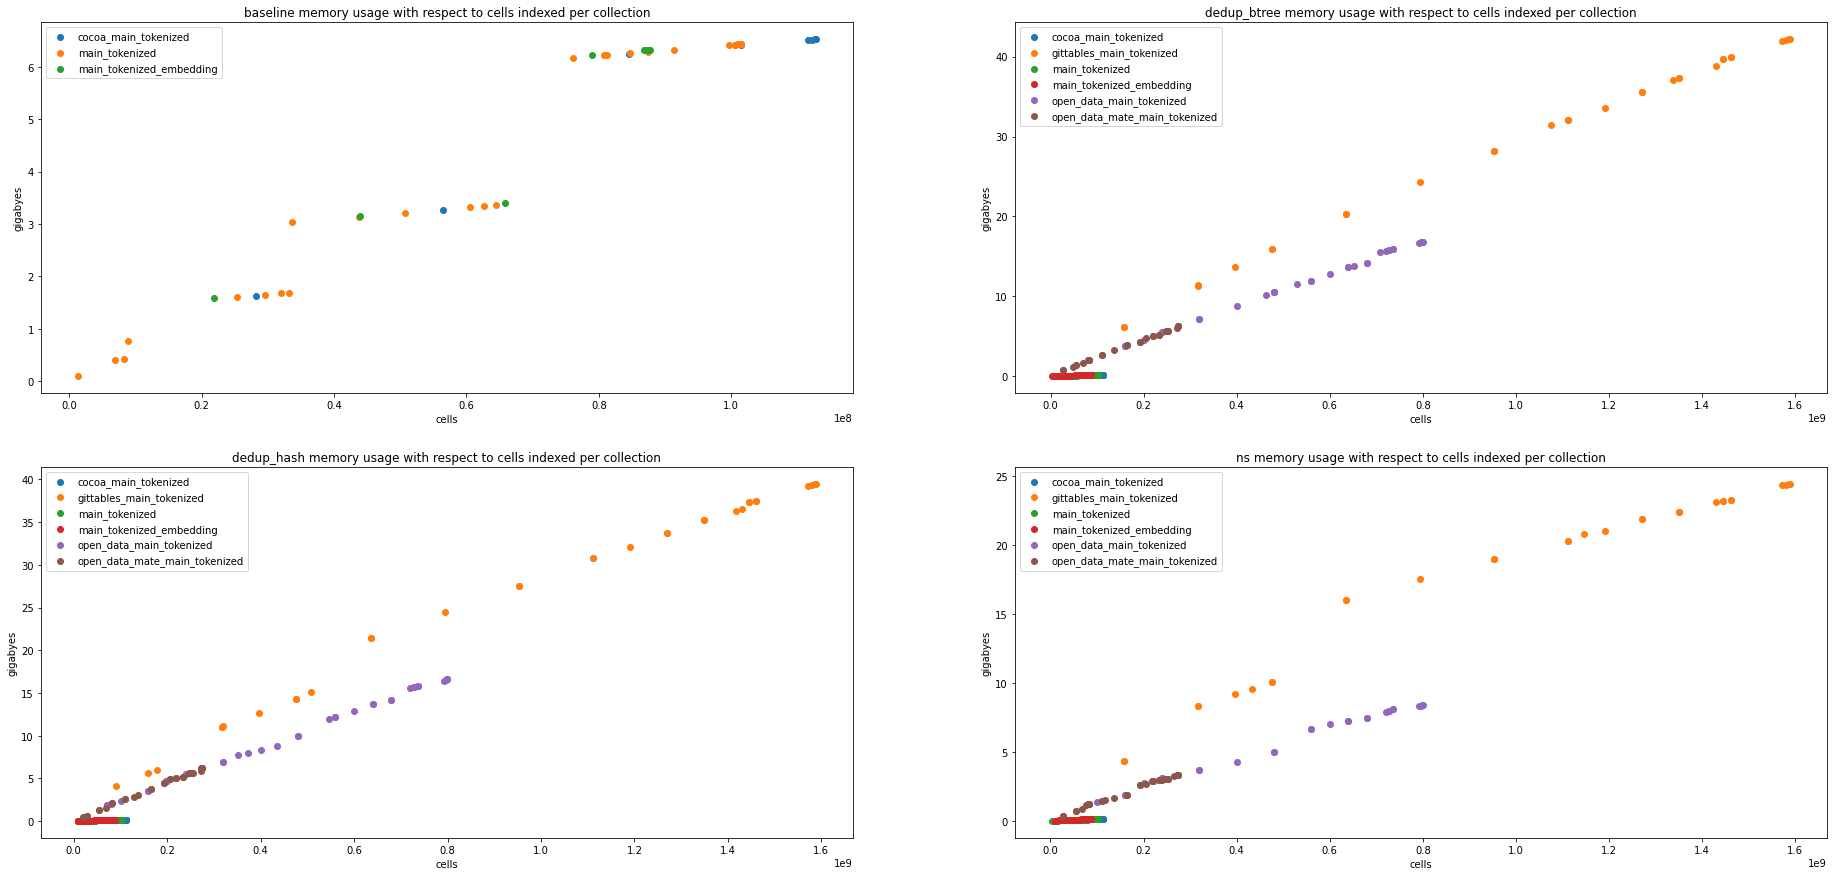

In [9]:
fig, [[baseline, dt], [dh, ns]] = plt.subplots(2,2, figsize=(32, 15))

data['bytes_gb'] = data["bytes"] * 1e-9

for [pt, id] in [(baseline, "baseline"), (dt, "dedup_btree"), (dh, "dedup_hash"), (ns, "ns")]:

    pt.set_title(id + " memory usage with respect to cells indexed per collection")
    pt.set_xlabel("cells")
    pt.set_ylabel("gigabyes")

    for t, row in data[data['algorithm'] == id].groupby("table"):
        pt.scatter("cells", "bytes_gb", data=row, label=t)


    pt.legend()


# Compression Rate is dependent on collections

Some algorithms behave wildly different on some collections like `main_tokenized`.

That is, because they consist almost completly and deduplicating them gives strong results.

Text(0.5, 1.0, 'index duration per collection')

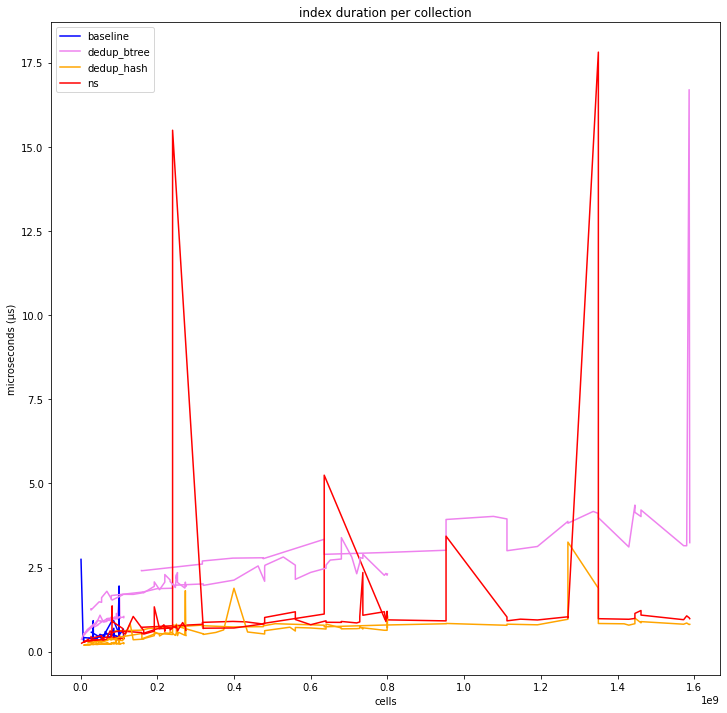

In [10]:

fig, ax = plt.subplots(figsize=(12, 12))

data['retr_duration_avg_microsec'] = data['retr_duration_avg_nanosec'] / 1000

data['retr_duration_avg_microsec_capped'] = np.array([min(5.0, elem) for elem in data['retr_duration_avg_microsec']])

done = set()
for [table,algo], row in data.groupby(["table", "algorithm"]):

    p, = ax.plot('cells', 'retr_duration_avg_microsec', c=c[algo], data=row, label="")

    if not algo in done:
        done.add(algo)
        p.set_label(algo)


ax.legend()
ax.set_ylabel('microseconds (μs)')
ax.set_xlabel('cells')
ax.set_title("index duration per collection")



# Spikes

Spikes during retrieval / indexing are relatively easy to explain, when looking at the data.

The key we index is sampled at random, chosen with each distinct key having the same probability to be picked.
However, some keys, e.g. cell values, make up more than 95% (check that number, e.g. main_tokenized an "0") of the entire dictionary.

That means we have to decode/copy an insane amount of values when indexing for a select few keys.

That makes the index time wildly hard to predict.

In [11]:
from math import sqrt


def pad(data, offset):
    data = np.insert(data, 0, np.ones(offset)*data[0])
    data = np.append(data, np.ones(offset)*data[-1])
    return data

def normalize(data):
    return data / sqrt(sum(data*data))

def apply_kernel(data, kernel):
    if len(kernel) % 2 != 1:
        raise "Kernel must have uneven amount of entries"

    kernel = normalize(np.array(kernel))

    # length of data without offset
    l = len(data)
    offset = (len(kernel)-1) >> 1

    data = pad(np.array(data), offset)

    slice = data[:l] * kernel[0]
    for i in range(1, len(kernel)):
        weight = kernel[i]
        end = i + l
        slice += data[i:end]

    return slice

smooth = lambda data: apply_kernel(data, [0.25, 0.75, 0.25])

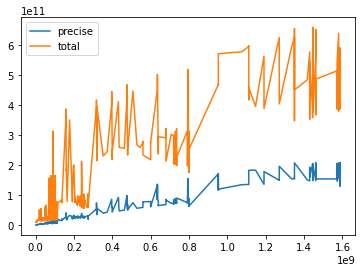

In [12]:
fig, ax = plt.subplots()
tt = "build_duration_total_nanosec"
raw = "build_duration_nanosec"
ax.plot("cells", tt, data=data, label="total")
ax.plot("cells", raw, data=data, label="precise")
ax.set_title('build duration with and without IO cost')
ax.legend()

## TODO 

- investigate relation between cardinality and access time
- investigate relation between cardinality and difference in compression (baseline vs dedup)

Text(0.5, 1.0, 'build time per algorithm')

<Figure size 432x288 with 0 Axes>

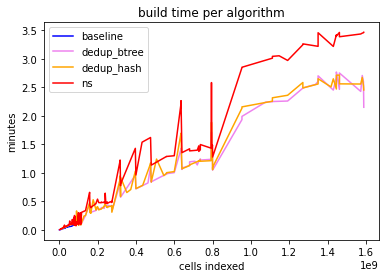

In [21]:
plt.figure(figsize=(6, 4))
fig, bta = plt.subplots()

data["build_duration_sec"] = data["build_duration_nanosec"] * 1e-9
data["build_duration_min"] = data["build_duration_sec"] / 60

for algo,row in data.groupby("algorithm"):
    p, = bta.plot('cells', 'build_duration_min', c=c[algo], data=row)
    p.set_label(algo)


bta.set_xlabel('cells indexed')
bta.set_ylabel('minutes')
bta.legend()
bta.set_title("build time per algorithm")

Text(0.5, 1.0, 'memory per table')

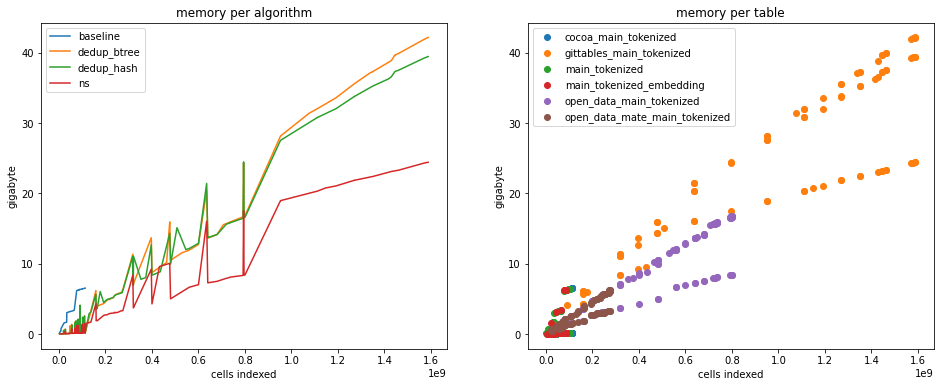

In [12]:
data['gigabyte'] = data['bytes'] / 1e9

fig,[mpa, mpt] = plt.subplots(1, 2, figsize=(16, 6))
for algo,row in data.groupby("algorithm"):
    p, = mpa.plot('cells', 'gigabyte',data=row)
    p.set_label(algo)
    # mpt.scatter('cells', 'gigabyte', data=row, label="")

mpa.set_xlabel('cells indexed')
mpa.set_ylabel('gigabyte')
mpa.legend()
mpa.set_title("memory per algorithm")

# now per table
#fig,mpt = plt.subplots(figsize=(16, 6))
for table,row in data.groupby("table"):
    p = mpt.scatter('cells', 'gigabyte', data=row)
    p.set_label(table)

mpt.set_xlabel('cells indexed')
mpt.set_ylabel('gigabyte')
mpt.legend()
mpt.set_title("memory per table")

the memory footprint is not dependant on the dataset at hand, but rather the amount of data consumed and the algorithm presented